In [149]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [150]:
with open('ei_intermediate_file_paths.json') as file_path_file:
    file_paths = json.load(file_path_file)


SI_PREDS_INPUT_PATH = file_paths.get("smoke_impact_model_predictions.csv")
NOAA_BLS_MERGED_INPUT_PATH = file_paths.get("stage2_fs_merged_output.csv")
EI_MODEL_INPUT_PATH = file_paths.get("ei_model_output")

EI_PREDS_OUTPUT_PATH = file_paths.get("economic_impact_model_predictions.csv")

In [151]:
# Load dataset
si_preds_df = pd.read_csv(SI_PREDS_INPUT_PATH)

noaa_bls_historical_df = pd.read_csv(NOAA_BLS_MERGED_INPUT_PATH)

In [152]:
print(si_preds_df.head(5))

print(si_preds_df.columns)

   year  predicted_total_acres_burned  predicted_avg_distance  \
0  2021                  2.351687e+06              359.010931   
1  2022                  2.351687e+06              359.010931   
2  2023                  2.351687e+06              359.010931   
3  2024                  2.351687e+06              359.010931   
4  2025                  2.351687e+06              359.010931   

   total_acres_burned_normalized  distance_normalized  \
0                       0.483929             0.552325   
1                       0.483929             0.552325   
2                       0.483929             0.552325   
3                       0.483929             0.552325   
4                       0.483929             0.552325   

   total_acres_burned_weighted  distance_weighted  predicted_smoke_impact  
0                     0.483929           0.552325               35.208975  
1                     0.483929           0.552325               35.208975  
2                     0.483929        

In [153]:
print(noaa_bls_historical_df.head(5))

print(noaa_bls_historical_df.columns)

         date    bls_date  bls_curr_sae_hrs  bls_curr_laus_labor_force  \
0  2009-09-01  2009-09-01              36.8                   421301.0   
1  2009-10-01  2009-10-01              36.7                   422913.0   
2  2010-05-01  2010-05-01              38.0                   415895.0   
3  2010-06-01  2010-06-01              37.9                   421034.0   
4  2010-07-01  2010-07-01              37.4                   423239.0   

   bls_curr_laus_unemployment_rate  bls_prev_yr_sae_hrs  \
0                              9.1                 37.4   
1                              8.8                 37.0   
2                              8.2                 37.4   
3                              8.7                 37.9   
4                              8.4                 37.1   

   bls_prev_yr_laus_labor_force  bls_prev_yr_laus_unemployment_rate  \
0                      427171.0                                 5.8   
1                      431740.0                           

In [154]:
# Convert the date column to datetime and extract month and year
noaa_bls_historical_df['date'] = pd.to_datetime(noaa_bls_historical_df['date'])
noaa_bls_historical_df['month'] = noaa_bls_historical_df['date'].dt.month
noaa_bls_historical_df['year'] = noaa_bls_historical_df['date'].dt.year

# Calculate 5-year rolling averages for each variable, considering only data from May to October for each year
noaa_bls_historical_df = noaa_bls_historical_df[noaa_bls_historical_df['month'].isin([5, 6, 7, 8, 9, 10])]

# Select relevant columns for grouping
group_columns = ['year', 'month','noaa_tavg', 'noaa_prcp', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']
noaa_bls_historical_df = noaa_bls_historical_df[group_columns]

# yearly_avg_df = noaa_bls_historical_df.groupby('year').mean().reset_index()

In [155]:
# Calculate monthly averages by year and month
monthly_avg_df = noaa_bls_historical_df.groupby(['year', 'month']).mean().reset_index()

# %% [Modified Calculating 3-Year Rolling Averages]
# Add 3-year rolling averages for May–October data
monthly_avg_df['3yr_avg_tavg'] = (
    monthly_avg_df.sort_values(by=['month', 'year'])  # Ensure data is sorted by month and year
    .groupby('month')['noaa_tavg']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(drop=True)
)

monthly_avg_df['3yr_avg_prcp'] = (
    monthly_avg_df.sort_values(by=['month', 'year'])
    .groupby('month')['noaa_prcp']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(drop=True)
)

monthly_avg_df['3yr_avg_pct_diff_sae_hrs'] = (
    monthly_avg_df.sort_values(by=['month', 'year'])
    .groupby('month')['bls_pct_diff_sae_hrs']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(drop=True)
)

monthly_avg_df['3yr_avg_pct_diff_labor_force'] = (
    monthly_avg_df.sort_values(by=['month', 'year'])
    .groupby('month')['bls_pct_diff_laus_labor_force']
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(drop=True)
)




In [156]:
print(monthly_avg_df.head(5))

print(monthly_avg_df.columns)

   year  month  noaa_tavg  noaa_prcp  bls_pct_diff_sae_hrs  \
0  2009      9       75.7       8.60             -1.604278   
1  2009     10       60.7      10.55             -0.810811   
2  2010      5       74.2       9.26              1.604278   
3  2010      6       84.6       0.31              0.000000   
4  2010      7       84.9       6.30              0.808625   

   bls_pct_diff_laus_labor_force  3yr_avg_tavg  3yr_avg_prcp  \
0                      -1.374157     74.200000      9.260000   
1                      -2.044518     72.200000      8.190000   
2                      -1.099358     73.566667      6.520000   
3                      -1.821175     72.033333      7.016667   
4                      -1.251738     72.433333      6.086667   

   3yr_avg_pct_diff_sae_hrs  3yr_avg_pct_diff_labor_force  
0                  1.604278                     -1.099358  
1                  0.012665                     -0.177831  
2                 -0.882822                     -0.628990  
3 

In [157]:
# %% [Modified Forecasting Future Data]
# Generate rows for May–October months for 2025–2050
future_months = pd.date_range(start="2025-05-01", end="2050-10-31", freq='MS')
future_predictions = pd.DataFrame({
    'year': future_months.year,
    'month': future_months.month,
    'predicted_tavg': np.nan,
    'predicted_prcp': np.nan,
    'predicted_pct_diff_sae_hrs': np.nan,
    'predicted_pct_diff_labor_force': np.nan
})

In [158]:
# Copy historical data into a temporary DataFrame to simulate adding future data
temp_data = monthly_avg_df.copy()

# %% [Modified Simulating Rolling Averages]
cycle_length = 3 * 6  # 3 years * 6 months per year (rolling window for monthly data)

for i, row in future_predictions.iterrows():
    # Assign predictions for this month based on the latest 3-year averages
    future_predictions.loc[i, 'predicted_tavg'] = temp_data['3yr_avg_tavg'].iloc[-1]
    future_predictions.loc[i, 'predicted_prcp'] = temp_data['3yr_avg_prcp'].iloc[-1]
    future_predictions.loc[i, 'predicted_pct_diff_sae_hrs'] = temp_data['3yr_avg_pct_diff_sae_hrs'].iloc[-1]
    future_predictions.loc[i, 'predicted_pct_diff_labor_force'] = temp_data['3yr_avg_pct_diff_labor_force'].iloc[-1]

    # Every cycle_length (18 months), update rolling averages
    if (i + 1) % cycle_length == 0:
        # Create a new row for the latest predictions as "historical" data
        new_row = pd.DataFrame({
            'year': [row['year']],
            'month': [row['month']],
            'noaa_tavg': [future_predictions.loc[i, 'predicted_tavg']],
            'noaa_prcp': [future_predictions.loc[i, 'predicted_prcp']],
            'bls_pct_diff_sae_hrs': [future_predictions.loc[i, 'predicted_pct_diff_sae_hrs']],
            'bls_pct_diff_laus_labor_force': [future_predictions.loc[i, 'predicted_pct_diff_labor_force']]
        })

        # Concatenate the new row to `temp_data`
        temp_data = pd.concat([temp_data, new_row], ignore_index=True)

        # Recalculate the 3-year rolling averages
        temp_data['3yr_avg_tavg'] = (
            temp_data.sort_values(by=['month', 'year'])
            .groupby('month')['noaa_tavg']
            .rolling(window=3, min_periods=1)
            .mean()
            .reset_index(drop=True)
        )
        temp_data['3yr_avg_prcp'] = (
            temp_data.sort_values(by=['month', 'year'])
            .groupby('month')['noaa_prcp']
            .rolling(window=3, min_periods=1)
            .mean()
            .reset_index(drop=True)
        )
        temp_data['3yr_avg_pct_diff_sae_hrs'] = (
            temp_data.sort_values(by=['month', 'year'])
            .groupby('month')['bls_pct_diff_sae_hrs']
            .rolling(window=3, min_periods=1)
            .mean()
            .reset_index(drop=True)
        )
        temp_data['3yr_avg_pct_diff_labor_force'] = (
            temp_data.sort_values(by=['month', 'year'])
            .groupby('month')['bls_pct_diff_laus_labor_force']
            .rolling(window=3, min_periods=1)
            .mean()
            .reset_index(drop=True)
        )

In [159]:
future_predictions = future_predictions.merge(si_preds_df[['year', 'predicted_smoke_impact']], on='year', how='left')


In [160]:
print(future_predictions)

     year  month  predicted_tavg  predicted_prcp  predicted_pct_diff_sae_hrs  \
0    2025      5       66.033333        3.723333                   -0.893212   
1    2025      6       66.033333        3.723333                   -0.893212   
2    2025      7       66.033333        3.723333                   -0.893212   
3    2025      8       66.033333        3.723333                   -0.893212   
4    2025      9       66.033333        3.723333                   -0.893212   
..    ...    ...             ...             ...                         ...   
301  2050      6       65.894533        3.180473                   -1.175321   
302  2050      7       65.894533        3.180473                   -1.175321   
303  2050      8       65.894533        3.180473                   -1.175321   
304  2050      9       65.894533        3.180473                   -1.175321   
305  2050     10       65.894533        3.180473                   -1.175321   

     predicted_pct_diff_labor_force  pr

In [161]:
# Load the trained model
with open(EI_MODEL_INPUT_PATH, 'rb') as model_file:
    economic_impact_model = pickle.load(model_file)

# Remap column names to the expected names for the model
future_predictions.rename(columns={
    'predicted_smoke_impact': 'scaled_avg_daily_smoke_impact',
    'predicted_tavg': 'noaa_tavg',
    'predicted_prcp': 'noaa_prcp',
    'predicted_pct_diff_sae_hrs': 'bls_pct_diff_sae_hrs',
    'predicted_pct_diff_labor_force': 'bls_pct_diff_laus_labor_force'
}, inplace=True)

In [162]:
print(future_predictions.head(5))

print(future_predictions.columns)

   year  month  noaa_tavg  noaa_prcp  bls_pct_diff_sae_hrs  \
0  2025      5  66.033333   3.723333             -0.893212   
1  2025      6  66.033333   3.723333             -0.893212   
2  2025      7  66.033333   3.723333             -0.893212   
3  2025      8  66.033333   3.723333             -0.893212   
4  2025      9  66.033333   3.723333             -0.893212   

   bls_pct_diff_laus_labor_force  scaled_avg_daily_smoke_impact  
0                       0.843564                      35.208975  
1                       0.843564                      35.208975  
2                       0.843564                      35.208975  
3                       0.843564                      35.208975  
4                       0.843564                      35.208975  
Index(['year', 'month', 'noaa_tavg', 'noaa_prcp', 'bls_pct_diff_sae_hrs',
       'bls_pct_diff_laus_labor_force', 'scaled_avg_daily_smoke_impact'],
      dtype='object')


In [163]:
# Prepare the data for prediction
# Select the required features for the model
prediction_features = ['noaa_tavg', 'noaa_prcp', 'scaled_avg_daily_smoke_impact', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force']

In [164]:
# Ensure future_predictions includes the required columns
X_future = future_predictions[prediction_features]

print(X_future)

# X_future.to_csv("X_future.csv")

     noaa_tavg  noaa_prcp  scaled_avg_daily_smoke_impact  \
0    66.033333   3.723333                      35.208975   
1    66.033333   3.723333                      35.208975   
2    66.033333   3.723333                      35.208975   
3    66.033333   3.723333                      35.208975   
4    66.033333   3.723333                      35.208975   
..         ...        ...                            ...   
301  65.894533   3.180473                      31.384901   
302  65.894533   3.180473                      31.384901   
303  65.894533   3.180473                      31.384901   
304  65.894533   3.180473                      31.384901   
305  65.894533   3.180473                      31.384901   

     bls_pct_diff_sae_hrs  bls_pct_diff_laus_labor_force  
0               -0.893212                       0.843564  
1               -0.893212                       0.843564  
2               -0.893212                       0.843564  
3               -0.893212                  

In [165]:
# Check for NaN values in the prediction features
nan_columns = future_predictions[prediction_features].isna().sum()

# Print columns with NaN values
print("Columns with NaN values and their counts:")
print(nan_columns[nan_columns > 0])


Columns with NaN values and their counts:
Series([], dtype: int64)


In [166]:
# Make predictions using the loaded model
future_predictions['pct_diff_laus_unemployment_rate'] = economic_impact_model.predict(X_future)

In [167]:
# Display the predictions
print(future_predictions)

     year  month  noaa_tavg  noaa_prcp  bls_pct_diff_sae_hrs  \
0    2025      5  66.033333   3.723333             -0.893212   
1    2025      6  66.033333   3.723333             -0.893212   
2    2025      7  66.033333   3.723333             -0.893212   
3    2025      8  66.033333   3.723333             -0.893212   
4    2025      9  66.033333   3.723333             -0.893212   
..    ...    ...        ...        ...                   ...   
301  2050      6  65.894533   3.180473             -1.175321   
302  2050      7  65.894533   3.180473             -1.175321   
303  2050      8  65.894533   3.180473             -1.175321   
304  2050      9  65.894533   3.180473             -1.175321   
305  2050     10  65.894533   3.180473             -1.175321   

     bls_pct_diff_laus_labor_force  scaled_avg_daily_smoke_impact  \
0                         0.843564                      35.208975   
1                         0.843564                      35.208975   
2                       

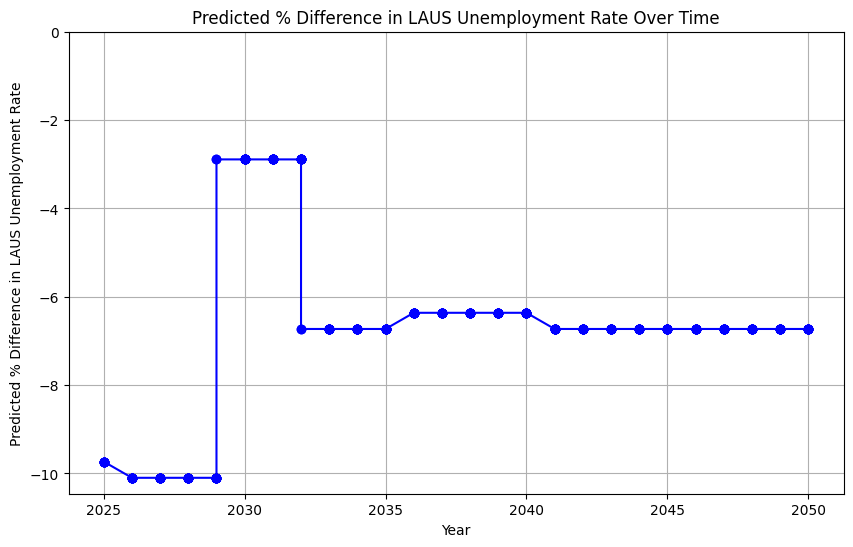

In [168]:
# Plot the predicted unemployment rate
plt.figure(figsize=(10, 6))
plt.plot(future_predictions['year'], future_predictions['pct_diff_laus_unemployment_rate'], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Predicted % Difference in LAUS Unemployment Rate')
plt.title('Predicted % Difference in LAUS Unemployment Rate Over Time')
plt.ylim(None, 0)  # Set the y-axis to start at 0 and let it scale automatically for the upper limit
plt.grid(True)
plt.show()


In [169]:
# Save the predictions to the output CSV file
future_predictions.to_csv(EI_PREDS_OUTPUT_PATH, index=False)
print(f"Predictions saved to {EI_PREDS_OUTPUT_PATH}")

Predictions saved to final-output/economic_impact_estimate_mdl_future_prediction.csv
